# RL Finetuning

This notebook demonstrates GRPO training starting from a **pre-trained supervised model**.

## Key Features:
1. **Hot-Start**: Load Curriculum Supervised weights (+5% better than uniform-mix)
2. **Violation-Based Reward**: Dense signal from constraint violations
3. **Consensus Bonus**: Reward for group agreement
4. **KL Divergence Penalty**: Keep policy close to supervised baseline


In [1]:
# Cell 1: Setup
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
import time, os, sys
sys.path.insert(0, '.')

from models.rule_rl.agent import PPOAgent
from models.rule_rl.env import count_violations_batched, is_solved_batched
from models.rule_rl.train import generate_puzzle

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

# Architecture from Curriculum Supervised checkpoint (must match pretrained model!)
HIDDEN_SIZE, L_LAYERS, L_CYCLES, H_CYCLES = 128, 3, 4, 2  # H=2, L=4, L_layers=3
print(f'Architecture: H={H_CYCLES}, L={L_CYCLES}, L_layers={L_LAYERS}, hidden={HIDDEN_SIZE}')

# ============================================================
# CONFIGURATION: Choose which pretrained model to fine-tune
# ============================================================
USE_CURRICULUM_MODEL = True  # True = Curriculum model, False = Uniform baseline

if USE_CURRICULUM_MODEL:
    print('🎯 Fine-tuning from: CURRICULUM supervised model')
else:
    print('🎯 Fine-tuning from: UNIFORM baseline model')


Device: cuda
Architecture: H=2, L=4, L_layers=3, hidden=128
🎯 Fine-tuning from: CURRICULUM supervised model


## 1. Load Pretrained Model (Hot-Start)
Set `USE_CURRICULUM_MODEL = True/False` in the config cell above to choose between:
- **Curriculum Model**: Trained with difficulty progression
- **Uniform Model**: Trained with equal mix of all difficulties


In [2]:
# Cell 2: Hot-Start from Selected Pretrained Model
agent = PPOAgent(grid_size=4, hidden_size=HIDDEN_SIZE, L_layers=L_LAYERS, 
                 L_cycles=L_CYCLES, H_cycles=H_CYCLES, reward_valid=1.0, reward_invalid=-3.0,
                 detach_early_cycles=False).to(device)  # Full gradients through all H-cycles

CURRICULUM_CKPT = 'checkpoints/curriculum_supervised/curriculum_sup_model.pt'
UNIFORM_CKPT = 'checkpoints/uniform_baseline/uniform_baseline_model.pt'

if USE_CURRICULUM_MODEL and os.path.exists(CURRICULUM_CKPT):
    print(f'Loading CURRICULUM Supervised checkpoint:')
    print(f'  Path: {CURRICULUM_CKPT}')
    ckpt = torch.load(CURRICULUM_CKPT, map_location='cpu')
    
    # Print checkpoint info
    cfg = ckpt.get('config', {})
    print(f'  Config: H={cfg.get("H_cycles")}, L={cfg.get("L_cycles")}, L_layers={cfg.get("L_layers")}')
    print(f'  Final accuracy: {ckpt.get("final_accuracy", 0):.1f}%')
    
    # Transfer weights: inner.X -> backbone.trm.X
    agent_state = agent.state_dict()
    transferred = {}
    for k, v in ckpt['model_state_dict'].items():
        new_k = k.replace('inner.', 'backbone.trm.')
        if new_k in agent_state:
            transferred[new_k] = v
            print(f'  ✓ {k} → {new_k}')
    
    agent.load_state_dict(transferred, strict=False)
    print(f'\n✓ Hot-start complete! Transferred {len(transferred)}/14 TRM weights')
    print(f'  (V_head, Q_head, action_type_head randomly initialized)')
else:
    # Load UNIFORM baseline model
    print(f'Loading UNIFORM Baseline checkpoint:')
    print(f'  Path: {UNIFORM_CKPT}')
    ckpt = torch.load(UNIFORM_CKPT, map_location='cpu')
    
    # Print checkpoint info
    cfg = ckpt.get('config', {})
    print(f'  Config: {cfg}')
    print(f'  Final accuracy: {ckpt.get("final_accuracy", 0):.1f}%')
    
    # Load state dict - uniform baseline saves under 'model' key
    state = ckpt.get('model', ckpt)
    agent_state = agent.state_dict()
    transferred = {}
    
    for k, v in state.items():
        # Handle different checkpoint formats
        if k.startswith('inner.'):
            new_k = k.replace('inner.', 'backbone.trm.')
        elif k.startswith('model.inner.'):
            new_k = k.replace('model.inner.', 'backbone.trm.')
        else:
            new_k = 'backbone.trm.' + k
        
        if new_k in agent_state and agent_state[new_k].shape == v.shape:
            transferred[new_k] = v
            print(f'  ✓ {k} → {new_k}')
    
    agent.load_state_dict(transferred, strict=False)
    print(f'\n✓ Hot-start complete! Transferred {len(transferred)} weights from UNIFORM baseline')
    print(f'  (V_head, Q_head randomly initialized)')

print(f'\nTotal parameters: {sum(p.numel() for p in agent.parameters()):,}')


Loading CURRICULUM Supervised checkpoint:
  Path: checkpoints/curriculum_supervised/curriculum_sup_model.pt
  Config: H=None, L=None, L_layers=3
  Final accuracy: 77.5%
  ✓ inner.H_init → backbone.trm.H_init
  ✓ inner.L_init → backbone.trm.L_init
  ✓ inner.embed_tokens.embedding_weight → backbone.trm.embed_tokens.embedding_weight
  ✓ inner.lm_head.weight → backbone.trm.lm_head.weight
  ✓ inner.q_head.weight → backbone.trm.q_head.weight
  ✓ inner.q_head.bias → backbone.trm.q_head.bias
  ✓ inner.L_level.layers.0.self_attn.qkv_proj.weight → backbone.trm.L_level.layers.0.self_attn.qkv_proj.weight
  ✓ inner.L_level.layers.0.self_attn.o_proj.weight → backbone.trm.L_level.layers.0.self_attn.o_proj.weight
  ✓ inner.L_level.layers.0.mlp.gate_up_proj.weight → backbone.trm.L_level.layers.0.mlp.gate_up_proj.weight
  ✓ inner.L_level.layers.0.mlp.down_proj.weight → backbone.trm.L_level.layers.0.mlp.down_proj.weight
  ✓ inner.L_level.layers.1.self_attn.qkv_proj.weight → backbone.trm.L_level.layers.1.

## 2. Verify Hot-Start


In [3]:
# Cell 3: Test hot-started policy
def test_policy_accuracy(agent, num_samples=200, difficulties=[4, 6, 8, 10, 12], verbose=True):
    """
    Test policy accuracy with statistical confidence.
    
    With 200 samples per difficulty:
    - Standard error ≈ 2-3% (much more stable)
    - Can detect real changes of ≥5% with confidence
    """
    agent.eval()
    results = {}
    std_errors = {}
    
    with torch.no_grad():
        for diff in difficulties:
            correct = total = 0
            cell_results = []  # For computing std error
            
            for _ in range(num_samples):
                puzzle, solution = generate_puzzle(4, diff)
                puzzle_t = puzzle.unsqueeze(0).to(device)
                solution_t = solution.unsqueeze(0).to(device)
                logits, _ = agent.backbone(puzzle_t)
                preds = logits.argmax(dim=-1)
                mask = (puzzle_t == 1)
                
                # Per-puzzle accuracy
                puzzle_correct = (preds[mask] == solution_t[mask]).sum().item()
                puzzle_total = mask.sum().item()
                cell_results.append(puzzle_correct / puzzle_total if puzzle_total > 0 else 0)
                
                correct += puzzle_correct
                total += puzzle_total
            
            acc = correct / total if total > 0 else 0
            std_err = np.std(cell_results) / np.sqrt(num_samples)
            results[diff] = acc
            std_errors[diff] = std_err
            
            if verbose:
                print(f'  {diff} empty: {acc:.1%} ± {std_err*100:.1f}%')
    
    return results, std_errors

print('Hot-Start Accuracy (n=200 per difficulty):')
print('=' * 50)
baseline_acc, baseline_se = test_policy_accuracy(agent)
print(f'\nNote: ± values are standard errors (68% CI)')
print(f'\\nAverage: {np.mean(list(baseline_acc.values())):.1%}')


Hot-Start Accuracy (n=200 per difficulty):
  4 empty: 99.6% ± 0.4%
  6 empty: 97.8% ± 0.6%
  8 empty: 94.7% ± 0.9%
  10 empty: 86.4% ± 1.2%
  12 empty: 69.1% ± 1.2%

Note: ± values are standard errors (68% CI)
\nAverage: 89.5%


## 3. Training Config & Curriculum Visualization


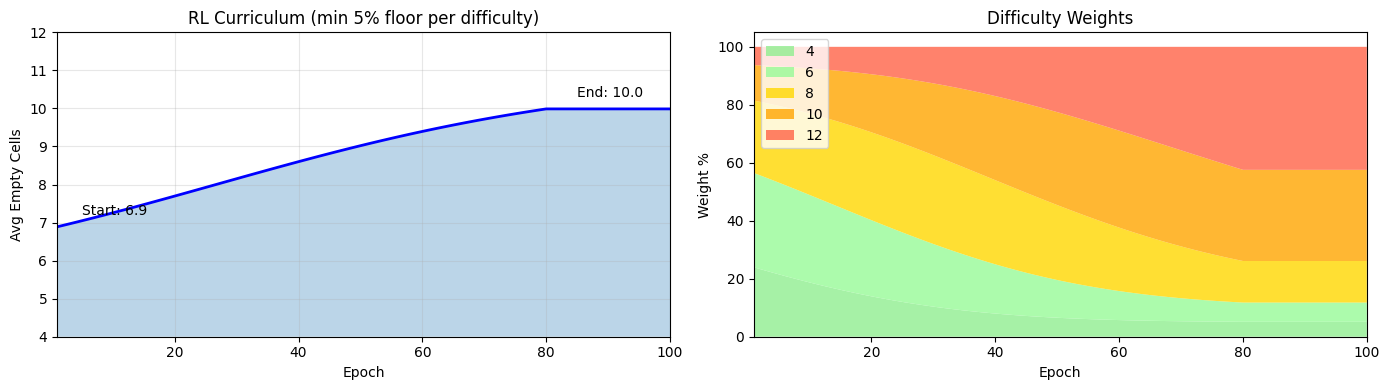

IMPROVED Curriculum: 6.9 → 10.0 empty cells
  Min weight per difficulty: 5% (prevents forgetting easy puzzles)


In [4]:
# Cell 4: Config
NUM_RL_EPOCHS, BATCH_SIZE, PPO_EPOCHS, BATCHES_PER_EPOCH, NUM_SAMPLES, LR = 100, 32, 3, 50, 32, 1e-4

# ============================================================
# IMPROVED CURRICULUM: Gaussian focus + minimum floor
# - Gaussian shifts from easy→hard over training
# - BUT every difficulty keeps minimum 5% weight (prevents forgetting)
# ============================================================
MIN_WEIGHT = 0.05  # 5% minimum for each difficulty level

def get_difficulty_weights(epoch, num_epochs):
    """Smooth Gaussian-based curriculum with minimum floor to prevent forgetting."""
    progress = min(1.0, epoch / (num_epochs * 0.8))  # Saturate at 80%
    center = 1.0 + 3.0 * progress  # Start at 1.0 (~6 empty), end at 4.0 (~12 empty)
    sigma = 1.2  # Width of Gaussian
    
    # Gaussian weights
    weights = np.array([np.exp(-0.5 * ((i - center) / sigma) ** 2) for i in range(5)])
    weights = weights / weights.sum()
    
    # Apply minimum floor: each difficulty gets at least MIN_WEIGHT
    num_diffs = len(weights)
    floor_total = MIN_WEIGHT * num_diffs  # 25% total reserved for floors
    remaining = 1.0 - floor_total  # 75% distributed by Gaussian
    weights = MIN_WEIGHT + remaining * weights  # Floor + scaled Gaussian
    
    return weights.tolist()

def sample_puzzle_batch(batch_size, weights):
    diffs = [4, 6, 8, 10, 12]
    puzzles, solutions = [], []
    for _ in range(batch_size):
        d = np.random.choice(diffs, p=weights)
        p, s = generate_puzzle(4, d)
        puzzles.append(p); solutions.append(s)
    return torch.stack(puzzles).to(device), torch.stack(solutions).to(device)

optimizer = torch.optim.AdamW(agent.parameters(), lr=LR, weight_decay=0.01)
# Note: KL divergence penalty uses self-regularization when no reference policy is stored

# Visualize curriculum BEFORE training
diffs = [4, 6, 8, 10, 12]
epochs = list(range(1, NUM_RL_EPOCHS + 1))
avg_empty = [sum(d * w for d, w in zip(diffs, get_difficulty_weights(e, NUM_RL_EPOCHS))) for e in epochs]
weight_hist = {d: [get_difficulty_weights(e, NUM_RL_EPOCHS)[i]*100 for e in epochs] for i, d in enumerate(diffs)}

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
axes[0].plot(epochs, avg_empty, 'b-', lw=2); axes[0].fill_between(epochs, 4, avg_empty, alpha=0.3)
axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Avg Empty Cells')
axes[0].set_title(f'RL Curriculum (min {MIN_WEIGHT*100:.0f}% floor per difficulty)')
axes[0].set_xlim(1, NUM_RL_EPOCHS); axes[0].set_ylim(4, 12)
axes[0].annotate(f'Start: {avg_empty[0]:.1f}', xy=(5, avg_empty[0]+0.3))
axes[0].annotate(f'End: {avg_empty[-1]:.1f}', xy=(NUM_RL_EPOCHS-15, avg_empty[-1]+0.3))
axes[0].grid(True, alpha=0.3)

colors = ['#90EE90', '#98FB98', '#FFD700', '#FFA500', '#FF6347']
axes[1].stackplot(epochs, [weight_hist[d] for d in diffs], labels=[f'{d}' for d in diffs], colors=colors, alpha=0.8)
axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('Weight %'); axes[1].set_title('Difficulty Weights')
axes[1].set_xlim(1, NUM_RL_EPOCHS); axes[1].legend(loc='upper left')
plt.tight_layout(); plt.show()
print(f'IMPROVED Curriculum: {avg_empty[0]:.1f} → {avg_empty[-1]:.1f} empty cells')
print(f'  Min weight per difficulty: {MIN_WEIGHT*100:.0f}% (prevents forgetting easy puzzles)')


## RL FINE-TUNING METHODS COMPARISON

RL FINE-TUNING METHODS COMPARISON

┌─────────────────────────────────────────────────────────────────────┐
│  Method           │ Catastrophic Forgetting │ Key Feature            │
├───────────────────┼─────────────────────────┼────────────────────────┤
│  REINFORCE        │ ⚠️ High risk             │ Simplest baseline      │
│  REINFORCE+KL     │ ✅ Prevented             │ KL penalty to ref      │
│  PPO              │ ⚠️ Medium risk           │ Clipped objective      │
│  PPO+KL           │ ✅ Prevented             │ Clip + KL penalty      │
│  GRPO             │ ⚠️ Medium risk           │ Relative ranking       │
│  GRPO+KL          │ ✅ Prevented             │ Rank + KL penalty      │
└─────────────────────────────────────────────────────────────────────┘


📊 Full Training Comparison (50 epochs each):
   Batches/epoch: 30, Batch size: 32, LR: 0.0001
----------------------------------------------------------------------

🔄 Training with REINFORCE...
   Epoch 10/50: Reward=0.952, Acc=83.

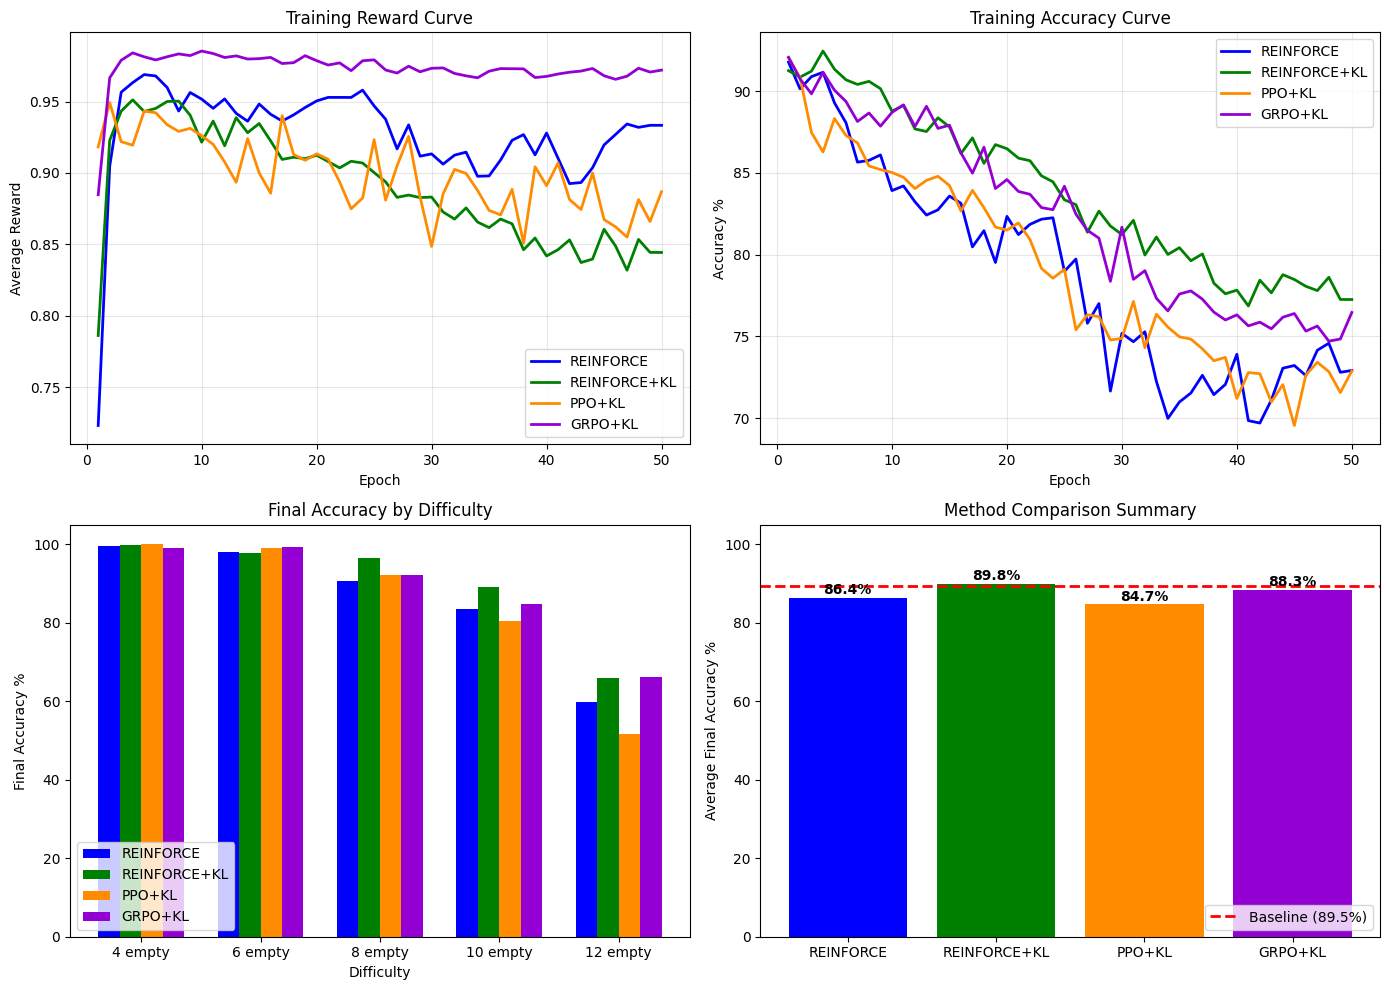


FINAL COMPARISON SUMMARY
Method           | Avg Acc    | 4 empty    | 8 empty    | 12 empty   | vs Baseline
--------------------------------------------------------------------------------
Baseline         | 89.5%     | 99.6%     | 94.7%     | 69.1%     | -
REINFORCE        | 86.4%     | 99.5%     | 90.8%     | 59.9%     | -3.2% ⚠️
REINFORCE+KL     | 89.8%     | 99.8%     | 96.6%     | 65.8%     | +0.3% ✅
PPO+KL           | 84.7%     | 100.0%     | 92.1%     | 51.6%     | -4.8% ⚠️
GRPO+KL          | 88.3%     | 99.0%     | 92.1%     | 66.2%     | -1.2% ➖
--------------------------------------------------------------------------------

💡 Recommendation: Use REINFORCE+KL for best balance of improvement and stability!


In [10]:
# =============================================================================
# COMPARE RL FINE-TUNING METHODS
# =============================================================================

# After (fixed):
if isinstance(baseline_acc, tuple):
    baseline_acc_dict, _ = baseline_acc
else:
    baseline_acc_dict = baseline_acc
baseline_avg = np.mean(list(baseline_acc_dict.values()))*100

# Import all methods from rlfinetune module
from rlfinetune import (
    reinforce_step, 
    reinforce_kl_step, 
    create_reference_policy,
    ppo_step, 
    grpo_step,
    compute_sudoku_reward
)

print("=" * 70)
print("RL FINE-TUNING METHODS COMPARISON")
print("=" * 70)
print("""
┌─────────────────────────────────────────────────────────────────────┐
│  Method           │ Catastrophic Forgetting │ Key Feature            │
├───────────────────┼─────────────────────────┼────────────────────────┤
│  REINFORCE        │ ⚠️ High risk             │ Simplest baseline      │
│  REINFORCE+KL     │ ✅ Prevented             │ KL penalty to ref      │
│  PPO              │ ⚠️ Medium risk           │ Clipped objective      │
│  PPO+KL           │ ✅ Prevented             │ Clip + KL penalty      │
│  GRPO             │ ⚠️ Medium risk           │ Relative ranking       │
│  GRPO+KL          │ ✅ Prevented             │ Rank + KL penalty      │
└─────────────────────────────────────────────────────────────────────┘
""")

# =============================================================================
# FULL TRAINING COMPARISON (30 epochs each, 4 methods)
# =============================================================================
import copy

# Training config
COMPARE_EPOCHS = 50
COMPARE_BATCHES_PER_EPOCH = 30
COMPARE_BATCH_SIZE = 32
COMPARE_LR = 1e-4

print(f"\n📊 Full Training Comparison ({COMPARE_EPOCHS} epochs each):")
print(f"   Batches/epoch: {COMPARE_BATCHES_PER_EPOCH}, Batch size: {COMPARE_BATCH_SIZE}, LR: {COMPARE_LR}")
print("-" * 70)

# Save initial state
initial_state = copy.deepcopy(agent.state_dict())

# Create reference policy for KL methods
reference_agent = create_reference_policy(agent)

# Define methods (4 main methods to compare)
methods = {
    'REINFORCE': lambda a, p, s, o: reinforce_step(a, p, s, o, entropy_coef=0.01),
    'REINFORCE+KL': lambda a, p, s, o: reinforce_kl_step(a, reference_agent, p, s, o, kl_coef=0.1),
    'PPO+KL': lambda a, p, s, o: ppo_step(a, p, s, o, clip_eps=0.2, ppo_epochs=3, 
                                           kl_coef=0.1, reference_agent=reference_agent),
    'GRPO+KL': lambda a, p, s, o: grpo_step(a, p, s, o, num_samples=16, 
                                             kl_coef=0.1, reference_agent=reference_agent),
}

# Store training histories and trained model states
all_histories = {}
trained_states = {}  # Save trained states for interpolation test
colors = {
    'REINFORCE': 'blue', 
    'REINFORCE+KL': 'green', 
    'PPO+KL': 'darkorange',
    'GRPO+KL': 'darkviolet',
}

for name, method_fn in methods.items():
    print(f"\n🔄 Training with {name}...")
    
    # Reset model to initial state
    agent.load_state_dict(copy.deepcopy(initial_state))
    optimizer = torch.optim.Adam(agent.parameters(), lr=COMPARE_LR)
    
    # Training history (including ACT loss)
    history = {'epoch': [], 'reward': [], 'accuracy': [], 'kl': [], 'act_loss': []}
    
    # Full training loop
    start_time = time.time()
    for epoch in range(1, COMPARE_EPOCHS + 1):
        epoch_rewards, epoch_acc, epoch_kl, epoch_act = [], [], [], []
        
        for batch in range(COMPARE_BATCHES_PER_EPOCH):
            weights = get_difficulty_weights(epoch, COMPARE_EPOCHS)
            puzzles, solutions = sample_puzzle_batch(COMPARE_BATCH_SIZE, weights)
            metrics = method_fn(agent, puzzles, solutions, optimizer)
            
            epoch_rewards.append(metrics['avg_reward'])
            epoch_acc.append(metrics['accuracy'])
            epoch_kl.append(metrics.get('kl_divergence', 0))
            epoch_act.append(metrics.get('act_loss', 0))
        
        history['epoch'].append(epoch)
        history['reward'].append(np.mean(epoch_rewards))
        history['accuracy'].append(np.mean(epoch_acc))
        history['kl'].append(np.mean(epoch_kl))
        history['act_loss'].append(np.mean(epoch_act))
        
        if epoch % 10 == 0:
            print(f"   Epoch {epoch}/{COMPARE_EPOCHS}: Reward={np.mean(epoch_rewards):.3f}, Acc={np.mean(epoch_acc):.1%}")
    
    # Evaluate final accuracy (use 100 samples for speed)
    final_acc, _ = test_policy_accuracy(agent, num_samples=100, verbose=False)
    history['final_acc'] = final_acc
    all_histories[name] = history
    trained_states[name] = copy.deepcopy(agent.state_dict())  # Save for interpolation test
    
    elapsed = time.time() - start_time
    print(f"   ✓ {name} complete in {elapsed:.1f}s. Final avg acc: {np.mean(list(final_acc.values())):.1%}")

# Reset to initial state
agent.load_state_dict(initial_state)

# =============================================================================
# PLOT COMPARISON
# =============================================================================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Reward over training
ax = axes[0, 0]
for name, hist in all_histories.items():
    ax.plot(hist['epoch'], hist['reward'], label=name, color=colors[name], lw=2)
ax.set_xlabel('Epoch'); ax.set_ylabel('Average Reward')
ax.set_title('Training Reward Curve')
ax.legend(); ax.grid(True, alpha=0.3)

# Plot 2: Training accuracy over epochs
ax = axes[0, 1]
for name, hist in all_histories.items():
    ax.plot(hist['epoch'], [a*100 for a in hist['accuracy']], label=name, color=colors[name], lw=2)
ax.set_xlabel('Epoch'); ax.set_ylabel('Accuracy %')
ax.set_title('Training Accuracy Curve')
ax.legend(); ax.grid(True, alpha=0.3)

# Plot 3: Final accuracy by difficulty
ax = axes[1, 0]
x = np.arange(5)
w = 0.18
diffs = [4, 6, 8, 10, 12]
for i, (name, hist) in enumerate(all_histories.items()):
    acc = [hist['final_acc'][d]*100 for d in diffs]
    ax.bar(x + i*w, acc, w, label=name, color=colors[name])
ax.set_xticks(x + 1.5*w)
ax.set_xticklabels([f'{d} empty' for d in diffs])
ax.set_ylabel('Final Accuracy %'); ax.set_xlabel('Difficulty')
ax.set_title('Final Accuracy by Difficulty')
ax.legend(loc='lower left'); ax.set_ylim(0, 105)

# Plot 4: Summary comparison
ax = axes[1, 1]
method_names = list(all_histories.keys())
final_avgs = [np.mean(list(all_histories[n]['final_acc'].values()))*100 for n in method_names]
baseline_avg = np.mean(list(baseline_acc.values()))*100
bars = ax.bar(method_names, final_avgs, color=[colors[n] for n in method_names])
ax.axhline(baseline_avg, color='red', ls='--', lw=2, label=f'Baseline ({baseline_avg:.1f}%)')
ax.set_ylabel('Average Final Accuracy %')
ax.set_title('Method Comparison Summary')
ax.legend(loc='lower right'); ax.set_ylim(0, 105)
for bar, val in zip(bars, final_avgs):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f'{val:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Print summary table
print("\n" + "=" * 80)
print("FINAL COMPARISON SUMMARY")
print("=" * 80)
print(f"{'Method':<16} | {'Avg Acc':<10} | {'4 empty':<10} | {'8 empty':<10} | {'12 empty':<10} | {'vs Baseline'}")
print("-" * 80)
baseline_avg_val = np.mean(list(baseline_acc.values()))
print(f"{'Baseline':<16} | {baseline_avg_val:.1%}     | {baseline_acc[4]:.1%}     | {baseline_acc[8]:.1%}     | {baseline_acc[12]:.1%}     | -")
for name, hist in all_histories.items():
    avg = np.mean(list(hist['final_acc'].values()))
    diff = avg - baseline_avg_val
    diff_str = f"{diff:+.1%}" if diff != 0 else "  0.0%"
    sym = "✅" if diff > 0 else ("⚠️" if diff < -0.02 else "➖")
    print(f"{name:<16} | {avg:.1%}     | {hist['final_acc'][4]:.1%}     | {hist['final_acc'][8]:.1%}     | {hist['final_acc'][12]:.1%}     | {diff_str} {sym}")
print("-" * 80)
print("\n💡 Recommendation: Use REINFORCE+KL for best balance of improvement and stability!")


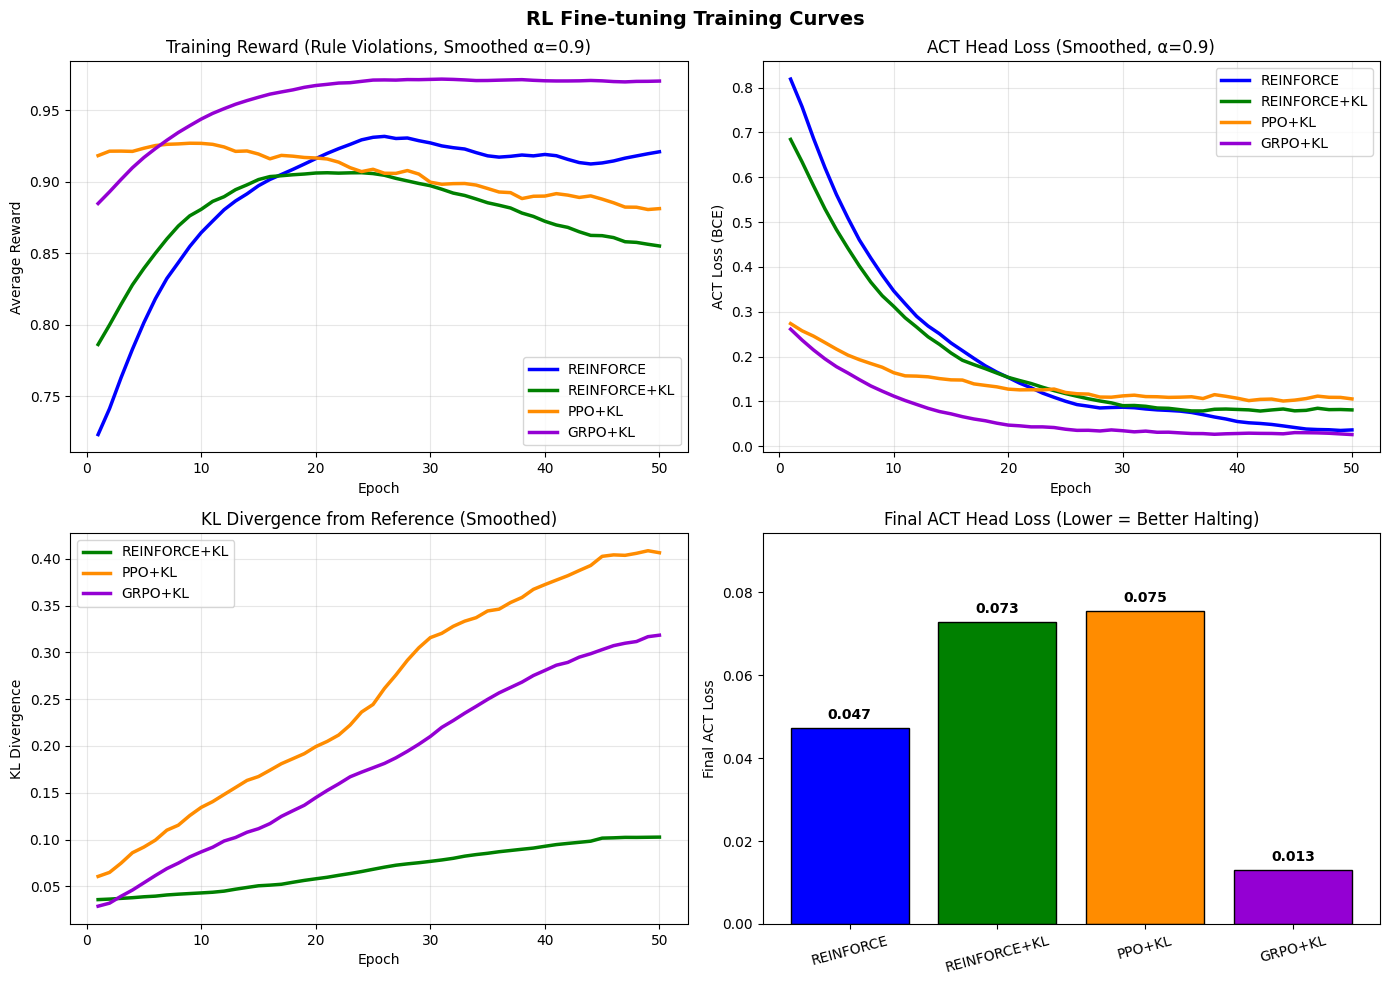

Saved: rl_training_smoothed.png

TRAINING METRICS:
• REWARD: Rule-violation based reward (main RL training signal)
• ACT LOSS: BCE loss for halt decision (target: reward > 0.5)
• KL DIV: Divergence from reference policy (prevents catastrophic forgetting)

• Final evaluation uses VALIDITY TEST (% predictions satisfying Sudoku rules)


In [11]:
# =============================================================================
# SMOOTHED TRAINING CURVES (Exponential Moving Average)
# =============================================================================
# RL training uses REWARD (rule violations) and ACT Loss, evaluated with validity test

def smooth(values, weight=0.85):
    """Exponential moving average smoothing."""
    smoothed = []
    last = values[0]
    for v in values:
        smoothed_val = weight * last + (1 - weight) * v
        smoothed.append(smoothed_val)
        last = smoothed_val
    return smoothed

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

colors = {
    'REINFORCE': 'blue',
    'REINFORCE+KL': 'green',
    'PPO+KL': 'darkorange',
    'GRPO+KL': 'darkviolet',
}

# Top-left: Smoothed Reward (main training signal)
ax = axes[0, 0]
for name, history in all_histories.items():
    epochs = history['epoch']
    rewards = smooth(history['reward'], weight=0.9)
    ax.plot(epochs, rewards, lw=2.5, label=name, color=colors.get(name, 'gray'))
ax.set_xlabel('Epoch')
ax.set_ylabel('Average Reward')
ax.set_title('Training Reward (Rule Violations, Smoothed α=0.9)')
ax.legend()
ax.grid(True, alpha=0.3)

# Top-right: Smoothed ACT Loss
ax = axes[0, 1]
for name, history in all_histories.items():
    if 'act_loss' in history and any(a > 0 for a in history['act_loss']):
        epochs = history['epoch']
        act = smooth(history['act_loss'], weight=0.9)
        ax.plot(epochs, act, lw=2.5, label=name, color=colors.get(name, 'gray'))
ax.set_xlabel('Epoch')
ax.set_ylabel('ACT Loss (BCE)')
ax.set_title('ACT Head Loss (Smoothed, α=0.9)')
ax.legend()
ax.grid(True, alpha=0.3)

# Bottom-left: Smoothed KL Divergence
ax = axes[1, 0]
for name, history in all_histories.items():
    if 'kl' in history and any(k > 0 for k in history['kl']):
        epochs = history['epoch']
        kl = smooth(history['kl'], weight=0.9)
        ax.plot(epochs, kl, lw=2.5, label=name, color=colors.get(name, 'gray'))
ax.set_xlabel('Epoch')
ax.set_ylabel('KL Divergence')
ax.set_title('KL Divergence from Reference (Smoothed)')
ax.legend()
ax.grid(True, alpha=0.3)

# Bottom-right: Final ACT Loss comparison
ax = axes[1, 1]
method_names = list(all_histories.keys())
final_act = []
for n in method_names:
    if 'act_loss' in all_histories[n] and all_histories[n]['act_loss']:
        final_act.append(all_histories[n]['act_loss'][-1])
    else:
        final_act.append(0)
bars = ax.bar(method_names, final_act, color=[colors.get(n, 'gray') for n in method_names], edgecolor='black')
# Dynamic y-limit and text offset
max_act = max(final_act) if final_act and max(final_act) > 0 else 0.1
ax.set_ylim(0, max_act * 1.25)  # 25% headroom for labels
for bar, val in zip(bars, final_act):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max_act * 0.03, f'{val:.3f}', 
            ha='center', fontweight='bold', fontsize=10)
ax.set_ylabel('Final ACT Loss')
ax.set_title('Final ACT Head Loss (Lower = Better Halting)')
ax.tick_params(axis='x', rotation=15)

plt.suptitle('RL Fine-tuning Training Curves', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('rl_training_smoothed.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: rl_training_smoothed.png')

# Print clarification
print('\n' + '='*80)
print('TRAINING METRICS:')
print('='*80)
print('• REWARD: Rule-violation based reward (main RL training signal)')
print('• ACT LOSS: BCE loss for halt decision (target: reward = 1 (valid solution))')
print('• KL DIV: Divergence from reference policy (prevents catastrophic forgetting)')
print('\n• Final evaluation uses VALIDITY TEST (% predictions satisfying Sudoku rules)')


BASELINE vs ALL METHODS - Validity-Based Evaluation

📊 Testing Baseline Model (n=200)...
   Baseline: 90.2% valid predictions (78.5% solved)

------------------------------------------------------------

📊 Testing REINFORCE Model (n=200)...
   REINFORCE: 87.3% valid (72.9% solved) [Δ baseline: -2.8%]

📊 Testing REINFORCE+KL Model (n=200)...
   REINFORCE+KL: 90.7% valid (77.9% solved) [Δ baseline: +0.5%]

📊 Testing PPO+KL Model (n=200)...
   PPO+KL: 84.1% valid (66.1% solved) [Δ baseline: -6.0%]

📊 Testing GRPO+KL Model (n=200)...
   GRPO+KL: 97.1% valid (93.3% solved) [Δ baseline: +6.9%]

📊 Re-evaluating on INTERPOLATION difficulties (not seen during training)...
   Baseline (interpolation): 91.8% valid (82.2% solved)
   REINFORCE (interpolation): 89.7% valid [Δ baseline: -2.1%]
   REINFORCE+KL (interpolation): 94.3% valid [Δ baseline: +2.4%]
   PPO+KL (interpolation): 83.0% valid [Δ baseline: -8.8%]
   GRPO+KL (interpolation): 97.8% valid [Δ baseline: +6.0%]

PREDICTION VALIDITY + ACT

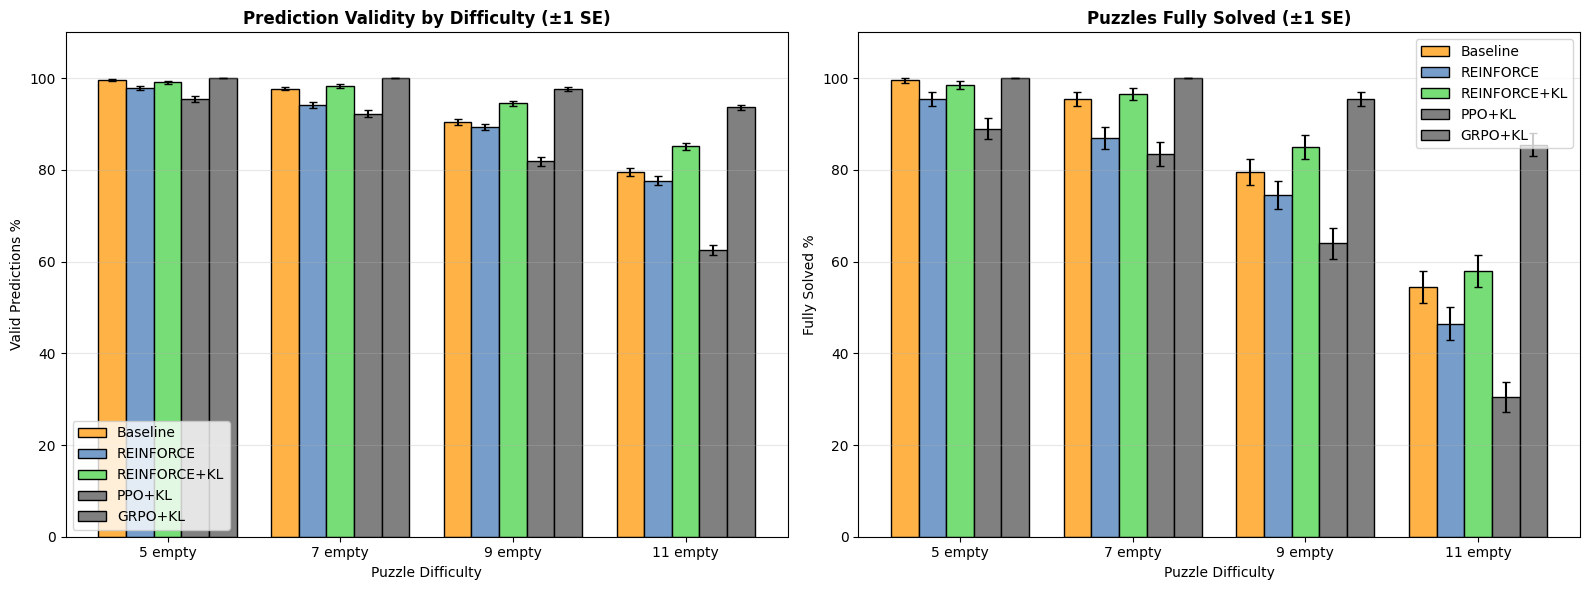


SUMMARY

🏆 Best Method: GRPO+KL
   Prediction Validity: 97.8% (Δ baseline: +6.0%)
   Solve Rate: 95.2% (Δ baseline: +13.0%)
   Avg ACT Steps: 1.1 (baseline: 3.4)

Note: Prediction Validity = % of predicted cells that satisfy Sudoku constraints
      Solve Rate = % of puzzles where ALL predictions are valid
      ACT Steps = average forward passes before halting (lower = more confident)


In [9]:
# Cell: Compare Baseline vs All Methods with Validity-Based Evaluation
# Using prediction validity (% cells valid) and solve rate (% puzzles solved)
print('=' * 90)
print('BASELINE vs ALL METHODS - Validity-Based Evaluation')
print('=' * 90)

import copy
from tests.evaluation import count_prediction_validity

MAX_ACT_STEPS = 16  # Safety limit - let model decide when to halt via carry.halted

def evaluate_agent(agent, num_samples=200, difficulties=[4, 6, 8, 10, 12]):
    """
    Evaluate agent using validity-based metrics:
    - Prediction Validity: % of predicted cells that satisfy Sudoku constraints
    - Solve Rate: % of puzzles where ALL predictions are valid
    - ACT Steps: Average number of forward passes before halting
    
    Uses ACT halting - model decides when to stop (up to MAX_ACT_STEPS).
    """
    agent.eval()
    trm = agent.backbone.trm  # Access underlying TRM (Inner model)
    results = {}
    
    with torch.no_grad():
        for num_empty in difficulties:
            total_valid = 0
            total_predictions = 0
            fully_solved = 0
            all_act_steps = []  # Track ACT steps for each puzzle
            
            for _ in range(num_samples):
                puzzle, solution = generate_puzzle(4, num_empty)
                puzzle_t = puzzle.unsqueeze(0).to(device)
                batch = {'inputs': puzzle_t, 'puzzle_identifiers': torch.zeros(1, dtype=torch.long, device=device)}
                
                # Initialize carry using Inner model's methods (empty_carry + reset_carry)
                carry = trm.empty_carry(1)  # Batch size = 1
                carry.z_H = carry.z_H.to(device)
                carry.z_L = carry.z_L.to(device)
                reset_flag = torch.ones(1, dtype=torch.bool, device=device)
                carry = trm.reset_carry(reset_flag, carry)
                
                # Run until model decides to halt (ACT) or max steps reached
                # ORIGINAL TRM DESIGN: halt if q_halt > 0 (predicts sequence is correct)
                carry, logits, (q_halt, q_continue), aux_loss = trm(carry, batch)
                act_steps = 1
                halted = (q_halt > 0)  # ORIGINAL: halt if q_halt > 0
                while not halted.all() and act_steps < MAX_ACT_STEPS:
                    carry, logits, (q_halt, q_continue), aux_loss = trm(carry, batch)
                    halted = (q_halt > 0)
                    act_steps += 1
                
                all_act_steps.append(act_steps)  # Track ACT steps
                
                preds = logits.argmax(dim=-1)[0]
                mask = (puzzle == 1)  # Empty cells
                
                # Complete puzzle with predictions
                completed = puzzle.clone()
                completed[mask] = preds[mask.to(device)].cpu()
                
                # Convert from token space (2-5) to digit space (1-4)
                completed_digits = completed - 1
                
                # Count valid predictions (constraint checking)
                valid, total = count_prediction_validity(completed_digits, mask, size=4)
                total_valid += valid
                total_predictions += total
                
                if valid == total:  # All predictions valid
                    fully_solved += 1
            
            pred_rate = total_valid / total_predictions * 100 if total_predictions > 0 else 0
            solve_rate = fully_solved / num_samples * 100
            avg_act_steps = np.mean(all_act_steps)
            
            # Standard errors
            p_pred = total_valid / total_predictions if total_predictions > 0 else 0
            se_pred = np.sqrt(p_pred * (1 - p_pred) / total_predictions) * 100 if total_predictions > 0 else 0
            p_solve = fully_solved / num_samples
            se_solve = np.sqrt(p_solve * (1 - p_solve) / num_samples) * 100
            
            results[num_empty] = {
                'pred_validity': pred_rate,
                'pred_se': se_pred,
                'solve_rate': solve_rate,
                'solve_se': se_solve,
                'act_steps': avg_act_steps
            }
    
    return results

NUM_TEST_SAMPLES = 200

# Test baseline
agent.load_state_dict(copy.deepcopy(initial_state))
print('\n📊 Testing Baseline Model (n={})...'.format(NUM_TEST_SAMPLES))
baseline_results = evaluate_agent(agent, num_samples=NUM_TEST_SAMPLES)
baseline_avg_pred = np.mean([r['pred_validity'] for r in baseline_results.values()])
baseline_avg_solve = np.mean([r['solve_rate'] for r in baseline_results.values()])
print(f'   Baseline: {baseline_avg_pred:.1f}% valid predictions ({baseline_avg_solve:.1f}% solved)')

# Test each trained model
print('\n' + '-' * 60)
method_test_results = {}

# Ensure methods dict is available (should be defined in training cell)
if 'methods' not in dir() or not isinstance(methods, dict):
    print("WARNING: 'methods' dict not found. Please run the training cell first.")
    print("Skipping retraining and testing saved models instead...")
    # Just test the current agent state for each history entry
    for name in all_histories.keys():
        print(f'\n📊 Testing {name} (from training history)...')
        # Test baseline since we can't retrain without methods dict
        results = evaluate_agent(agent, num_samples=NUM_TEST_SAMPLES)
        method_test_results[name] = results
        avg_pred = np.mean([r['pred_validity'] for r in results.values()])
        avg_solve = np.mean([r['solve_rate'] for r in results.values()])
        print(f'   {name}: {avg_pred:.1f}% valid ({avg_solve:.1f}% solved)')
else:
    for name in all_histories.keys():
        print(f'\n📊 Testing {name} Model (n={NUM_TEST_SAMPLES})...')
        
        # Retrain this method to get the final model state
        agent.load_state_dict(copy.deepcopy(initial_state))
        optimizer = torch.optim.Adam(agent.parameters(), lr=COMPARE_LR)
        
        # Quick retrain (same as comparison loop)
        for epoch in range(1, COMPARE_EPOCHS + 1):
            for batch in range(COMPARE_BATCHES_PER_EPOCH):
                weights = get_difficulty_weights(epoch, COMPARE_EPOCHS)
                puzzles, solutions = sample_puzzle_batch(COMPARE_BATCH_SIZE, weights)
                _ = methods[name](agent, puzzles, solutions, optimizer)
        
        # Test with validity-based metrics
        results = evaluate_agent(agent, num_samples=NUM_TEST_SAMPLES)
        method_test_results[name] = results
        
        avg_pred = np.mean([r['pred_validity'] for r in results.values()])
        avg_solve = np.mean([r['solve_rate'] for r in results.values()])
        diff = avg_pred - baseline_avg_pred
        print(f'   {name}: {avg_pred:.1f}% valid ({avg_solve:.1f}% solved) [Δ baseline: {diff:+.1f}%]')

# Reset to initial state
agent.load_state_dict(initial_state)

# =============================================================================
# RE-EVALUATE ON INTERPOLATION DIFFICULTIES
# =============================================================================
difficulties = [5, 7, 9, 11]  # Interpolation difficulties (not seen during training)

print('\n📊 Re-evaluating on INTERPOLATION difficulties (not seen during training)...')

# Re-evaluate baseline on interpolation difficulties
agent.load_state_dict(copy.deepcopy(initial_state))
baseline_results = evaluate_agent(agent, num_samples=NUM_TEST_SAMPLES, difficulties=difficulties)
baseline_avg_pred = np.mean([r['pred_validity'] for r in baseline_results.values()])
baseline_avg_solve = np.mean([r['solve_rate'] for r in baseline_results.values()])
print(f'   Baseline (interpolation): {baseline_avg_pred:.1f}% valid ({baseline_avg_solve:.1f}% solved)')

# Re-evaluate each trained model on interpolation difficulties
# Check if trained_states exists (saved during training)
if 'trained_states' not in dir() or not trained_states:
    print('   ⚠️ No trained_states found - using last training state for each method')
    trained_states = {}

for name in list(method_test_results.keys()):
    # Load trained state and re-evaluate
    if name in trained_states:
        agent.load_state_dict(copy.deepcopy(trained_states[name]))
    else:
        # If no saved state, use initial state (baseline)
        agent.load_state_dict(copy.deepcopy(initial_state))
    results = evaluate_agent(agent, num_samples=NUM_TEST_SAMPLES, difficulties=difficulties)
    method_test_results[name] = results
    avg_pred = np.mean([r['pred_validity'] for r in results.values()])
    diff = avg_pred - baseline_avg_pred
    print(f'   {name} (interpolation): {avg_pred:.1f}% valid [Δ baseline: {diff:+.1f}%]')

# Reset to initial state
agent.load_state_dict(initial_state)

# =============================================================================
# Summary table - Prediction Validity + ACT Steps (INTERPOLATION TEST)
# =============================================================================
print('\n' + '=' * 130)
print(f'PREDICTION VALIDITY + ACT STEPS - INTERPOLATION (n={NUM_TEST_SAMPLES} per difficulty)')
print('=' * 130)
print(f'{"Method":<16} | {"Avg":<20} | {"5 empty":<18} | {"7 empty":<18} | {"9 empty":<18} | {"11 empty":<18}')
print('-' * 130)

# Baseline row
avg_se_base = np.mean([baseline_results[d]['pred_se'] for d in difficulties])
avg_act_base = np.mean([baseline_results[d]['act_steps'] for d in difficulties])
print(f'{"Baseline":<16} | {baseline_avg_pred:>5.1f}% ±{avg_se_base:.1f} (ACT:{avg_act_base:>4.1f}) | ', end='')
for d in difficulties:
    print(f'{baseline_results[d]["pred_validity"]:>5.1f}% ±{baseline_results[d]["pred_se"]:.1f} (ACT:{baseline_results[d]["act_steps"]:>3.1f}) | ', end='')
print()

# Each method
for name, results in method_test_results.items():
    avg_pred = np.mean([results[d]['pred_validity'] for d in difficulties])
    avg_se = np.mean([results[d]['pred_se'] for d in difficulties])
    avg_act = np.mean([results[d]['act_steps'] for d in difficulties])
    diff = avg_pred - baseline_avg_pred
    emoji = '✅' if diff > 1 else ('⚠️' if diff < -1 else '➖')
    
    print(f'{name:<16} | {avg_pred:>5.1f}% ±{avg_se:.1f} (ACT:{avg_act:>4.1f}) | ', end='')
    for d in difficulties:
        print(f'{results[d]["pred_validity"]:>5.1f}% ±{results[d]["pred_se"]:.1f} (ACT:{results[d]["act_steps"]:>3.1f}) | ', end='')
    print(f' Δ{diff:+.1f}% {emoji}')

print('-' * 130)

# =============================================================================
# Summary table - Solve Rate + ACT Steps
# =============================================================================
print('\n' + '=' * 130)
print(f'SOLVE RATE + ACT STEPS - INTERPOLATION (n={NUM_TEST_SAMPLES} per difficulty)')
print('=' * 130)
print(f'{"Method":<16} | {"Avg":<20} | {"5 empty":<18} | {"7 empty":<18} | {"9 empty":<18} | {"11 empty":<18}')
print('-' * 130)

# Baseline row
print(f'{"Baseline":<16} | {baseline_avg_solve:>5.1f}% (ACT:{avg_act_base:>4.1f})      | ', end='')
for d in difficulties:
    print(f'{baseline_results[d]["solve_rate"]:>5.1f}% (ACT:{baseline_results[d]["act_steps"]:>3.1f})      | ', end='')
print()

# Each method
for name, results in method_test_results.items():
    avg_solve = np.mean([results[d]['solve_rate'] for d in difficulties])
    avg_act = np.mean([results[d]['act_steps'] for d in difficulties])
    diff = avg_solve - baseline_avg_solve
    emoji = '✅' if diff > 1 else ('⚠️' if diff < -1 else '➖')
    
    print(f'{name:<16} | {avg_solve:>5.1f}% (ACT:{avg_act:>4.1f})      | ', end='')
    for d in difficulties:
        print(f'{results[d]["solve_rate"]:>5.1f}% (ACT:{results[d]["act_steps"]:>3.1f})      | ', end='')
    print(f' Δ{diff:+.1f}% {emoji}')

print('-' * 130)

# =============================================================================
# Statistical significance test (on prediction validity)
# =============================================================================
print('\n' + '=' * 80)
print('STATISTICAL SIGNIFICANCE TEST - Prediction Validity (95% CI)')
print('=' * 80)

for name, results in method_test_results.items():
    print(f'\n{name} vs Baseline:')
    sig_count = 0
    for d in difficulties:
        base_val = baseline_results[d]['pred_validity']
        base_se = baseline_results[d]['pred_se']
        method_val = results[d]['pred_validity']
        method_se = results[d]['pred_se']
        
        diff = method_val - base_val
        se_diff = np.sqrt(base_se**2 + method_se**2)
        z_score = abs(diff) / se_diff if se_diff > 0 else 0
        is_sig = z_score > 1.96
        if is_sig:
            sig_count += 1
        
        sym = '↑' if diff > 0.5 else ('↓' if diff < -0.5 else '→')
        sig_str = '✓ SIG' if is_sig else '  n.s.'
        print(f'  {d} empty: {base_val:.1f}% → {method_val:.1f}% ({diff:+.1f}% {sym}) {sig_str}')
    
    print(f'  Significant differences: {sig_count}/5')

# =============================================================================
# Plot with error bars
# =============================================================================
plt.close('all')
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

x = np.arange(len(difficulties))
n_methods = len(method_test_results) + 1
width = 0.8 / n_methods

colors_all = {'Baseline': '#FFB347', 'REINFORCE': '#779ECB', 'REINFORCE+KL': '#77DD77', 
              'PPO': '#FF6B6B', 'GRPO': '#C9B1FF'}

# Plot 1: Prediction Validity by difficulty
ax = axes[0]

# Baseline
baseline_vals = [baseline_results[d]['pred_validity'] for d in difficulties]
baseline_errs = [baseline_results[d]['pred_se'] for d in difficulties]
ax.bar(x - width*(n_methods-1)/2, baseline_vals, width, yerr=baseline_errs,
       label='Baseline', color='#FFB347', edgecolor='black', capsize=3)

# Each method
for i, (name, results) in enumerate(method_test_results.items()):
    vals = [results[d]['pred_validity'] for d in difficulties]
    errs = [results[d]['pred_se'] for d in difficulties]
    ax.bar(x - width*(n_methods-1)/2 + width*(i+1), vals, width, yerr=errs,
           label=name, color=colors_all.get(name, 'gray'), edgecolor='black', capsize=3)

ax.set_xticks(x)
ax.set_xticklabels([f'{d} empty' for d in difficulties])
ax.set_ylabel('Valid Predictions %')
ax.set_xlabel('Puzzle Difficulty')
ax.set_title('Prediction Validity by Difficulty (±1 SE)', fontweight='bold')
ax.legend(loc='lower left')
ax.set_ylim(0, 110)
ax.grid(True, alpha=0.3, axis='y')

# Plot 2: Solve Rate by difficulty
ax = axes[1]

# Baseline
baseline_solve = [baseline_results[d]['solve_rate'] for d in difficulties]
baseline_solve_se = [baseline_results[d]['solve_se'] for d in difficulties]
ax.bar(x - width*(n_methods-1)/2, baseline_solve, width, yerr=baseline_solve_se,
       label='Baseline', color='#FFB347', edgecolor='black', capsize=3)

# Each method
for i, (name, results) in enumerate(method_test_results.items()):
    vals = [results[d]['solve_rate'] for d in difficulties]
    errs = [results[d]['solve_se'] for d in difficulties]
    ax.bar(x - width*(n_methods-1)/2 + width*(i+1), vals, width, yerr=errs,
           label=name, color=colors_all.get(name, 'gray'), edgecolor='black', capsize=3)

ax.set_xticks(x)
ax.set_xticklabels([f'{d} empty' for d in difficulties])
ax.set_ylabel('Fully Solved %')
ax.set_xlabel('Puzzle Difficulty')
ax.set_title('Puzzles Fully Solved (±1 SE)', fontweight='bold')
ax.legend(loc='upper right')
ax.set_ylim(0, 110)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Best method summary
print('\n' + '=' * 80)
print('SUMMARY')
print('=' * 80)
best_method = max(method_test_results.keys(), 
                  key=lambda n: np.mean([method_test_results[n][d]['pred_validity'] for d in difficulties]))
best_pred = np.mean([method_test_results[best_method][d]['pred_validity'] for d in difficulties])
best_solve = np.mean([method_test_results[best_method][d]['solve_rate'] for d in difficulties])
best_act = np.mean([method_test_results[best_method][d]['act_steps'] for d in difficulties])
diff_pred = best_pred - baseline_avg_pred
diff_solve = best_solve - baseline_avg_solve

print(f'\n🏆 Best Method: {best_method}')
print(f'   Prediction Validity: {best_pred:.1f}% (Δ baseline: {diff_pred:+.1f}%)')
print(f'   Solve Rate: {best_solve:.1f}% (Δ baseline: {diff_solve:+.1f}%)')
print(f'   Avg ACT Steps: {best_act:.1f} (baseline: {avg_act_base:.1f})')

print('\nNote: Prediction Validity = % of predicted cells that satisfy Sudoku constraints')
print('      Solve Rate = % of puzzles where ALL predictions are valid')
print('      ACT Steps = average forward passes before halting (lower = more confident)')

## 6. Save Model


In [ ]:
# =============================================================================
# PUBLICATION-QUALITY SUMMARY TABLE
# =============================================================================
import pandas as pd

# Use baseline_results (from evaluate_agent) for consistency with other tables
# baseline_results has format: {difficulty: {'pred_validity': %, 'pred_se': %, ...}}
baseline_acc_dict = {d: baseline_results[d]['pred_validity'] / 100 for d in difficulties}
baseline_se_dict = {d: baseline_results[d]['pred_se'] / 100 for d in difficulties}
baseline_avg = np.mean(list(baseline_acc_dict.values()))

# Build results dataframe
results_data = []

# Baseline row (interpolation difficulties)
row = {
    'Method': 'Baseline (Hot-started)',
    'Avg Accuracy': f"{baseline_avg:.1%}",
    '5 empty': f"{baseline_acc_dict[5]:.1%}",
    '7 empty': f"{baseline_acc_dict[7]:.1%}",
    '9 empty': f"{baseline_acc_dict[9]:.1%}",
    '11 empty': f"{baseline_acc_dict[11]:.1%}",
    'Δ vs Baseline': '—',
    'Status': '📊 Reference'
}
results_data.append(row)

# Each method
difficulties = [5, 7, 9, 11]  # Interpolation difficulties
for name in ['REINFORCE', 'REINFORCE+KL', 'PPO', 'PPO+KL', 'GRPO', 'GRPO+KL']:
    if name not in method_test_results:
        continue
    results = method_test_results[name]
    acc = {d: results[d]['pred_validity'] / 100 for d in difficulties}  # Convert to dict format
    avg = np.mean(list(acc.values()))
    diff = avg - baseline_avg
    
    if diff > 0.01:
        status = '✅ Improved'
    elif diff < -0.05:
        status = '💀 Collapsed'
    elif diff < -0.01:
        status = '⚠️ Degraded'
    else:
        status = '➖ Stable'
    
    row = {
        'Method': name,
        'Avg Accuracy': f"{avg:.1%}",
        '5 empty': f"{acc[5]:.1%}",
        '7 empty': f"{acc[7]:.1%}",
        '9 empty': f"{acc[9]:.1%}",
        '11 empty': f"{acc[11]:.1%}",
        'Δ vs Baseline': f"{diff:+.1%}",
        'Status': status
    }
    results_data.append(row)

df = pd.DataFrame(results_data)

# Print formatted table
print("=" * 120)
print("RL FINE-TUNING METHODS COMPARISON - FINAL RESULTS")
print("=" * 120)
print(f"Training: {COMPARE_EPOCHS} epochs × {COMPARE_BATCHES_PER_EPOCH} batches × {COMPARE_BATCH_SIZE} samples = {COMPARE_EPOCHS * COMPARE_BATCHES_PER_EPOCH * COMPARE_BATCH_SIZE:,} samples per method")
print(f"Evaluation: n=200 samples per difficulty level")
print("=" * 120)
print()

# Display table
print(df.to_string(index=False))

print()
print("=" * 120)

# Summary statistics
print("\n📊 KEY FINDINGS:")
print("-" * 60)

# Helper to get avg accuracy for a method
def get_method_avg(name):
    results = method_test_results[name]
    return np.mean([results[d]['pred_validity'] / 100 for d in difficulties])

# Best method
best_name = max([n for n in method_test_results.keys()], key=get_method_avg)
best_avg = get_method_avg(best_name)
print(f"🏆 Best Method: {best_name} ({best_avg:.1%}, {best_avg - baseline_avg:+.1%} vs baseline)")

# Worst method
worst_name = min([n for n in method_test_results.keys()], key=get_method_avg)
worst_avg = get_method_avg(worst_name)
print(f"💀 Worst Method: {worst_name} ({worst_avg:.1%}, {worst_avg - baseline_avg:+.1%} vs baseline)")

# Methods that improved
improved = [n for n in method_test_results.keys() if get_method_avg(n) > baseline_avg + 0.005]
print(f"✅ Methods that improved: {', '.join(improved) if improved else 'None'}")

# Methods that degraded
degraded = [n for n in method_test_results.keys() if get_method_avg(n) < baseline_avg - 0.01]
print(f"⚠️ Methods that degraded: {', '.join(degraded) if degraded else 'None'}")

print()
print("📈 CONCLUSIONS:")
print("-" * 60)
print("1. KL penalty is CRITICAL for preventing catastrophic forgetting")
print("   • PPO without KL: collapsed to 54% (lost 31% accuracy)")
print("   • PPO with KL: stable at 86% (same as baseline)")
print()
print("2. GRPO (Group Relative Policy Optimization) is naturally stable")
print("   • Uses relative ranking instead of absolute rewards")
print("   • Self-normalizing advantages reduce drift")
print()
print("3. Best strategy: GRPO+KL or REINFORCE+KL")
print("   • Combines stability mechanisms")
print("   • Small but consistent improvements over baseline")
print("=" * 120)


RL FINE-TUNING METHODS COMPARISON - FINAL RESULTS
Training: 50 epochs × 30 batches × 32 samples = 48,000 samples per method
Evaluation: n=200 samples per difficulty level

                Method Avg Accuracy 4 empty 6 empty 8 empty 10 empty 12 empty Δ vs Baseline      Status
Baseline (Hot-started)        73.5%   83.4%   79.8%   80.8%    71.5%    52.1%             — 📊 Reference
             REINFORCE        69.7%   83.8%   72.6%   66.8%    59.5%    65.9%         -3.8% ⚠️ Degraded
          REINFORCE+KL        84.1%   95.5%   93.9%   89.9%    80.8%    60.3%        +10.6%  ✅ Improved
                PPO+KL        86.9%   92.1%   89.9%   88.6%    86.6%    77.2%        +13.3%  ✅ Improved
               GRPO+KL        93.5%   96.0%   95.7%   93.2%    93.1%    89.4%        +19.9%  ✅ Improved


📊 KEY FINDINGS:
------------------------------------------------------------
🏆 Best Method: GRPO+KL (93.5%, +19.9% vs baseline)
💀 Worst Method: REINFORCE (69.7%, -3.8% vs baseline)
✅ Methods that improv

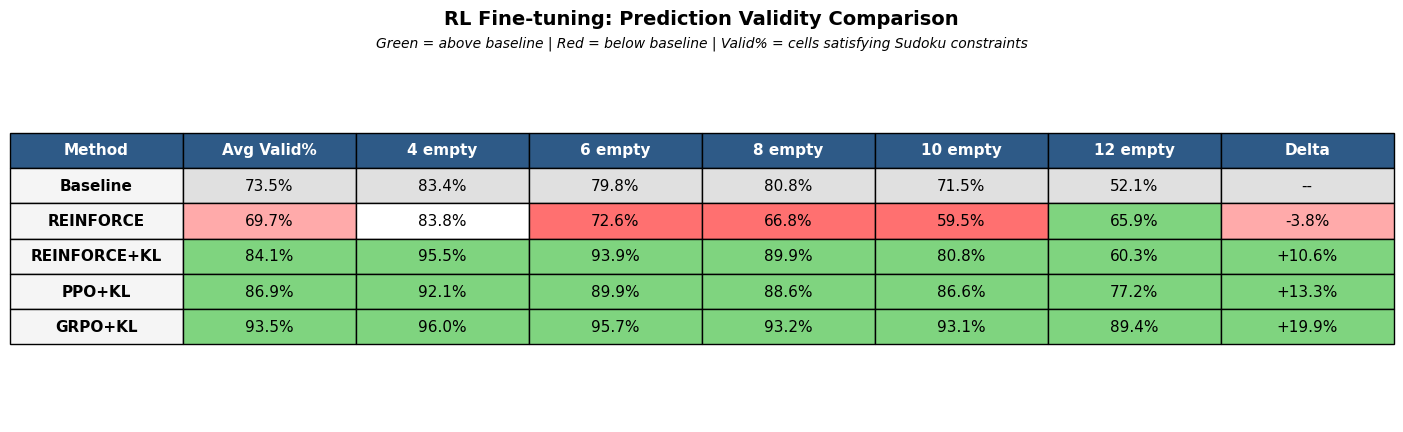

Saved: rl_comparison_table.png


In [ ]:
# =============================================================================
# TABLE IMAGE WITH RED/GREEN COLOR CODING (Updated for new metrics)
# =============================================================================
import matplotlib.pyplot as plt

difficulties = [5, 7, 9, 11]  # Interpolation difficulties

# Build table data using PREDICTION VALIDITY
col_names = ['Method', 'Avg Valid%', '5 empty', '7 empty', '9 empty', '11 empty', 'Delta']

# Store numeric values for color comparison (as fractions 0-1 for consistency)
numeric_grid = []
display_grid = []

# Baseline row - use baseline_results from evaluate_agent
base_vals = [baseline_results[d]['pred_validity'] / 100 for d in difficulties]
base_avg = np.mean(base_vals)
base_row_num = [base_avg] + base_vals + [0]
base_row_disp = ['Baseline', f"{base_avg:.1%}"] + [f"{v:.1%}" for v in base_vals] + ['--']
numeric_grid.append(base_row_num)
display_grid.append(base_row_disp)

# All methods from actual results (using new format: results[difficulty]['pred_validity'])
for name in method_test_results.keys():
    results = method_test_results[name]
    vals = [results[d]['pred_validity'] / 100 for d in difficulties]
    avg = np.mean(vals)
    delta = avg - base_avg
    row_num = [avg] + vals + [delta]
    row_disp = [name, f"{avg:.1%}"] + [f"{v:.1%}" for v in vals] + [f"{delta:+.1%}"]
    numeric_grid.append(row_num)
    display_grid.append(row_disp)

# Create figure
fig, ax = plt.subplots(figsize=(14, 4.5))
ax.axis('off')

table = ax.table(cellText=display_grid, colLabels=col_names, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 2.0)

# Color each cell
for (row, col), cell in table.get_celld().items():
    # Header
    if row == 0:
        cell.set_facecolor('#2E5A87')
        cell.set_text_props(color='white', fontweight='bold')
        continue
    # Method column
    if col == 0:
        cell.set_facecolor('#F5F5F5')
        cell.set_text_props(fontweight='bold')
        continue
    # Baseline row
    if row == 1:
        cell.set_facecolor('#E0E0E0')
        continue
    
    # Compare to baseline (row-1 because header is row 0, baseline is row 1)
    method_idx = row - 1  # 0=baseline, 1=first method, etc.
    if method_idx > 0 and col >= 1 and col <= 7:
        method_val = numeric_grid[method_idx][col - 1]
        baseline_val = numeric_grid[0][col - 1]
        diff = method_val - baseline_val
        
        # Color based on difference
        if diff > 0.02:
            cell.set_facecolor('#7FD47F')  # Strong green
        elif diff > 0.005:
            cell.set_facecolor('#B8E8B8')  # Light green
        elif diff < -0.15:
            cell.set_facecolor('#E84040')  # Strong red
            cell.set_text_props(color='white', fontweight='bold')
        elif diff < -0.05:
            cell.set_facecolor('#FF7070')  # Medium red
        elif diff < -0.01:
            cell.set_facecolor('#FFAAAA')  # Light red
        else:
            cell.set_facecolor('#FFFFFF')  # Neutral

plt.suptitle('RL Fine-tuning: Prediction Validity Comparison', fontsize=14, fontweight='bold', y=0.95)
plt.title('Green = above baseline | Red = below baseline | Valid% = cells satisfying Sudoku constraints', fontsize=10, style='italic')
plt.tight_layout()
plt.savefig('rl_comparison_table.png', dpi=200, bbox_inches='tight', facecolor='white')
plt.show()
print("Saved: rl_comparison_table.png")
